## Decision Trees

In [1]:
feature_names = ["feature 1", "feature 2"]

class TreeNode():
    def print( self, depth = 0 ):
        raise NotImplementedError()            
    def predict( self, x ):
        raise NotImplementedError()
        
class LeafNode( TreeNode ):
    def __init__( self, output_class, confidence ):
        self.output_class = output_class
        self.confidence = confidence

    def print( self, depth = 0 ):
        print( "  " * depth, "Leaf Node", self.output_class, self.confidence )
    
    def predict( self, x ):
        return self.output_class, self.confidence

class InnerNode( TreeNode ):
    def __init__( self, feature, split_value, left_child, right_child ):
        self.feature = feature
        self.split_value = split_value
        self.left_child = left_child
        self.right_child = right_child

    def print( self, depth = 0 ):
        print( "  " * depth, "Inner Node (", feature_names[self.feature], "<", self.split_value, ")" )
        self.left_child.print( depth + 1 )
        self.right_child.print( depth + 1 )
    
    def predict( self, x ):
        if x[ self.feature ] <= self.split_value:
            return self.left_child.predict( x )
        return self.right_child.predict( x )

## Aufbauen eines Decision Trees

In [3]:
import numpy as np

def count_occurance_of_class( data_points, searched_class ):
    occurences = 0
    for _, y in data_points:
        if y == searched_class:
            occurences += 1
    
    return occurences

def get_unqiue_classes( data_points ):
    unique_classes = set()
    for _, y in data_points:
        unique_classes.add(y)
    
    return list(unique_classes)

def gini_index( data_points, classes ):
    sum_ = 0
    for c in classes:
        p_class = count_occurance_of_class(data_points, c) / len(data_points)
        sum_ += p_class ** 2

    return 1 - sum_

def split_data( data_points, feature, split_value ):
    left = []
    right = []

    for x, y in data_points:
        left.append((x, y)) if x[feature] <= split_value else right.append((x, y))

    return left, right

def suggest_split_values( data_points, feature ): # feature = index of feature in x to be split
    feature_values = [x[feature] for x, _ in data_points]

    return np.median(feature_values)

def select_best_split( data_points, features, classes ):
    best_feature = 0
    best_split_value = 0.0
    best_impurity = float("inf")

    for feature in features:
        suggested_split_value = suggest_split_values(data_points, feature)
        data_left, data_right = split_data(data_points, feature, suggested_split_value)
        impurity = gini_index(data_left, classes) + gini_index(data_right, classes)

        if impurity < best_impurity:
            best_feature = feature
            best_split_value = suggested_split_value
            best_impurity = impurity
    
    return ( best_feature, best_split_value ) 

def build_tree( data_points ):
    # Abbruchkriterium: Nur noch eine Klasse oder weniger als 5 Datenpunkte in datapoints
    unique_classes_in_data = get_unqiue_classes(data_points)

    if len(unique_classes_in_data) == 1 or len(data_points) <= 5:
        occurances = []
        for _, y in data_points:
            occurances.append((y, count_occurance_of_class(y, data_points)))
            c, o = sorted(occurances, key=lambda point: point[0])[0]
            return LeafNode(c, o / len(data_points))
    
    best_feature, best_split_value = select_best_split(data_points, list(range(len(data_points[0][0]))), unique_classes_in_data)
    left_data, right_data = split_data(data_points, best_feature, best_split_value)

    left_child = build_tree(left_data)
    right_child = build_tree(right_data)
    return InnerNode(best_feature, best_split_value, left_child, right_child)

## Preparing Synthetic Dataset 

100 -46.59945135621088
100 33.652430739473175


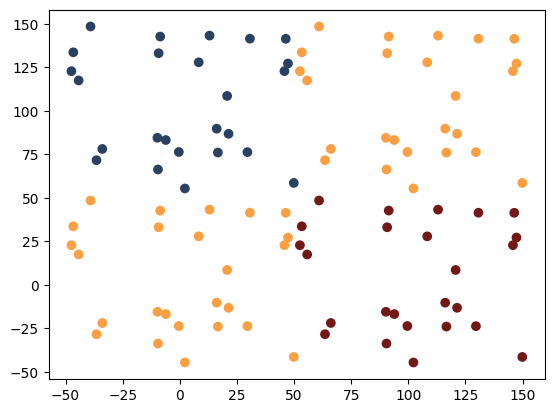

TypeError: 'type' object is not iterable

In [4]:
import random

colors = ["#eaeaf2", "#721817", "#2b4162", "#fa9f42"]

data_points = []
for i in range(25):
    noiseA = random.uniform(-50, 50)
    noiseB = random.uniform(-50, 50)
    data_points.append( ( [  0+noiseA,   0+noiseB], colors[3]) )
    data_points.append( ( [100+noiseA,   0+noiseB], colors[1]) )
    data_points.append( ( [  0+noiseA, 100+noiseB], colors[2]) )
    data_points.append( ( [100+noiseA, 100+noiseB], colors[3]) )

import matplotlib.pyplot as plt 

X = [a[0][0] for a in data_points]
Y = [a[0][1] for a in data_points]
D = [a[1] for a in data_points]
print( len(X), X[0] )
print( len(Y), Y[0]  )
plt.scatter(X, Y, c=D)
plt.savefig("dataset_synthetic.png", dpi=300, bbox_inches='tight')
plt.show()

tree = build_tree(data_points)
tree.print()

x = [ 25.0, 125.0 ]
prediction = tree.predict( x )
print(prediction)

In [6]:
import csv

class FileFormatException(Exception):
    def __init__(self, line_number):
        super().__init__()
        self.line_number = line_number
        
def load_csv_in_sklearn_format( input_file_name, output_feature ):
    with open(input_file_name, 'r') as file:
        reader = csv.reader(file, delimiter=";")
        X = []
        Y = []
        for line_number,row in enumerate(reader):
            if line_number==0:
                n_features = len( row )
                input_features = []
                for i in range(n_features):
                    if i != output_feature:
                        input_features.append(i)               
            if len(row) != n_features:
                raise FileFormatException(line_number)
            try:
                features = []
                for i in input_features:
                    features.append(float(row[i]))
                X.append( features )
                Y.append( row[output_feature] )
            except Exception: 
                raise FileFormatException(line_number)
    return X, Y

In [7]:
import unittest

class TestNotebook(unittest.TestCase):

    def test_load_correct_file(self):
        x,y = load_csv_in_sklearn_format("iris_data.csv", output_feature=4)
        self.assertTrue(type(x) is list)
        self.assertEqual(len(x), 150)        
        self.assertTrue(type(x[0]) is list)
        self.assertEqual(len(x[0]), 4)        
        self.assertTrue(type(y) is list)
        self.assertEqual(len(y), 150)

    def test_load_corrupt_file(self):
        with self.assertRaises(FileFormatException) as cm:
            x,y = load_csv_in_sklearn_format("corrupt_dataset.csv", output_feature=4)

unittest.main(argv=[''], verbosity=2, exit=False)

test_load_correct_file (__main__.TestNotebook) ... ok
test_load_corrupt_file (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


In [8]:
X, Y = load_csv_in_sklearn_format("iris_data.csv", output_feature=4)
feature_names = ["Kelchblattlänge", "Kelchblattdicke", "Blütenblattlänge", "Blütenblattdicke"]
data_points = list ( zip( X, Y ) )

tree = build_tree( data_points )
tree.print()

 Leaf Node 0 1.0
